The goal of this notebook is to probe the dynamics of HIV infection spread in men who have sex with men (MSM) populations using in silico simulations.

Assume that the nodes represent MSMs. An initial percentage of 5% of men are infected with HIV. In this work, consider 4 cases: (1) use prep properly and use condom, (2) use prep improperly and use condom, (3) didn't use prep and use condom, (4) unprotected sex. 

The failure rate of prep is 0.01; the failure rate of condom is 0.02, the failure rate of improper use of prep is 0.02. The failure rate or transmission rate of unprotected sex is 0.01 per act. If the intercourse is unprotected, let the transmission rate be defined by: $1 - (1-0.01)^{n_{contacts}}$, where $n_{contacts}$ is the number of sexual acts over the course. If the intercourse is protected, let the transmission rate be defined by: (failure rate of prep whether proper or improper) x (failure rate of condom). 


At a particular time t, select Z nodes to initiate a sexual contact. Each node will choose a sexual contact from his neighbors. The number of contacts at once can be greater than one, and is selected randomly between 1 to 5. If 5 is chosen, this means that the node will select at most 3 partners to do sex at that time. Throughout the simulation, the following are also tracked: (1) list of sexual partners of each node through a dictionary `dictSexPartners` and (2) the number of sexual partners of node $X$ at time $t$ through a dictionary named `dictNumPartners`. 

For the network structure: let 25% of men in the network are using pre-exposure prophylaxis (PrEP), 70% of those also use condoms and 30% do not. Furthermore, among the 25% of men who use prep, 50% of them are using it properly. For those who don't use PrEP, they engage in unprotected intercourse. 


`igraph` library is used in the simulations, and random geometric networks defined by radius $R$ were used. 

From here, I probe the proportion of infected after $t$=500 iterations under a $Z$-at-a-time infection procedure. I set $N=100$, $R \in [0,1.3]$, $Z=50$.

In [4]:
import igraph as ig
import numpy as np
import random

def simulate_hiv_spread(R, t_max=50, initial_infected_rate=0.05,Z = 1):
    # Create a random geometric graph
    n = 1000  # Number of nodes
    g = ig.Graph.GRG(n, R)
    
    # Initialize infection status
    infected = np.random.choice([0, 1], size=n, p=[1-initial_infected_rate, initial_infected_rate])
    
    # Initialize dictionaries to track sexual partners and number of partners
    dictSexPartners = {i: [] for i in range(n)}
    dictNumPartners = {i: 0 for i in range(n)}
    
    # Initialize list to track number of infected over time
    listInfected = [np.sum(infected)]
    
    # Define failure rates
    prep_proper_failure = 0.01
    prep_improper_failure = 0.02
    condom_failure = 0.02
    unprotected_failure_per_act = 0.01
    
    # Define proportions
    prep_users = 0.25
    condom_users_among_prep = 0.70
    proper_prep_users = 0.50
    
    # Assign prep and condom usage
    prep_status = np.random.choice([0, 1], size=n, p=[1-prep_users, prep_users])
    proper_prep_status = np.random.choice([0, 1], size=n, p=[1-proper_prep_users, proper_prep_users])
    condom_status = np.random.choice([0, 1], size=n, p=[1-condom_users_among_prep, condom_users_among_prep])
    
    for t in range(t_max):
        # Z = random.randint(1, 10)
        nodes_initiating_contact = random.sample(range(n), Z)
        
        for node in nodes_initiating_contact:
            n_contacts = random.randint(1, 5)
            partners = random.sample(g.neighbors(node), min(n_contacts, len(g.neighbors(node))))
            
            for partner in partners:
                dictSexPartners[node].append(partner)
                dictNumPartners[node] += 1
                
                if infected[node] == 1 and infected[partner] == 0:
                    if prep_status[partner] == 1:
                        if proper_prep_status[partner] == 1:
                            prep_failure = prep_proper_failure
                        else:
                            prep_failure = prep_improper_failure
                        
                        if condom_status[partner] == 1:
                            transmission_rate = prep_failure * condom_failure
                        else:
                            transmission_rate = prep_failure
                    else:
                        transmission_rate = 1 - (1 - unprotected_failure_per_act) ** n_contacts
                    
                    if random.random() < transmission_rate:
                        infected[partner] = 1
        
        listInfected.append(np.sum(infected))
    
    return listInfected, dictSexPartners, dictNumPartners

# Run the simulation for different values of R
final_infection_sizes = []
combined_values = np.concatenate((np.arange(0, 1.3, 0.1), np.logspace(np.log10(0.01), np.log10(0.001), 5),  np.logspace(np.log10(0.01), np.log10(0.1), 5)))
R_values = np.unique(np.sort(combined_values))

for R in R_values:
    listInfected, dictSexPartners, dictNumPartners = simulate_hiv_spread(R, t_max=500, Z=50)
    final_infection_sizes.append(listInfected[-1] / 1000)

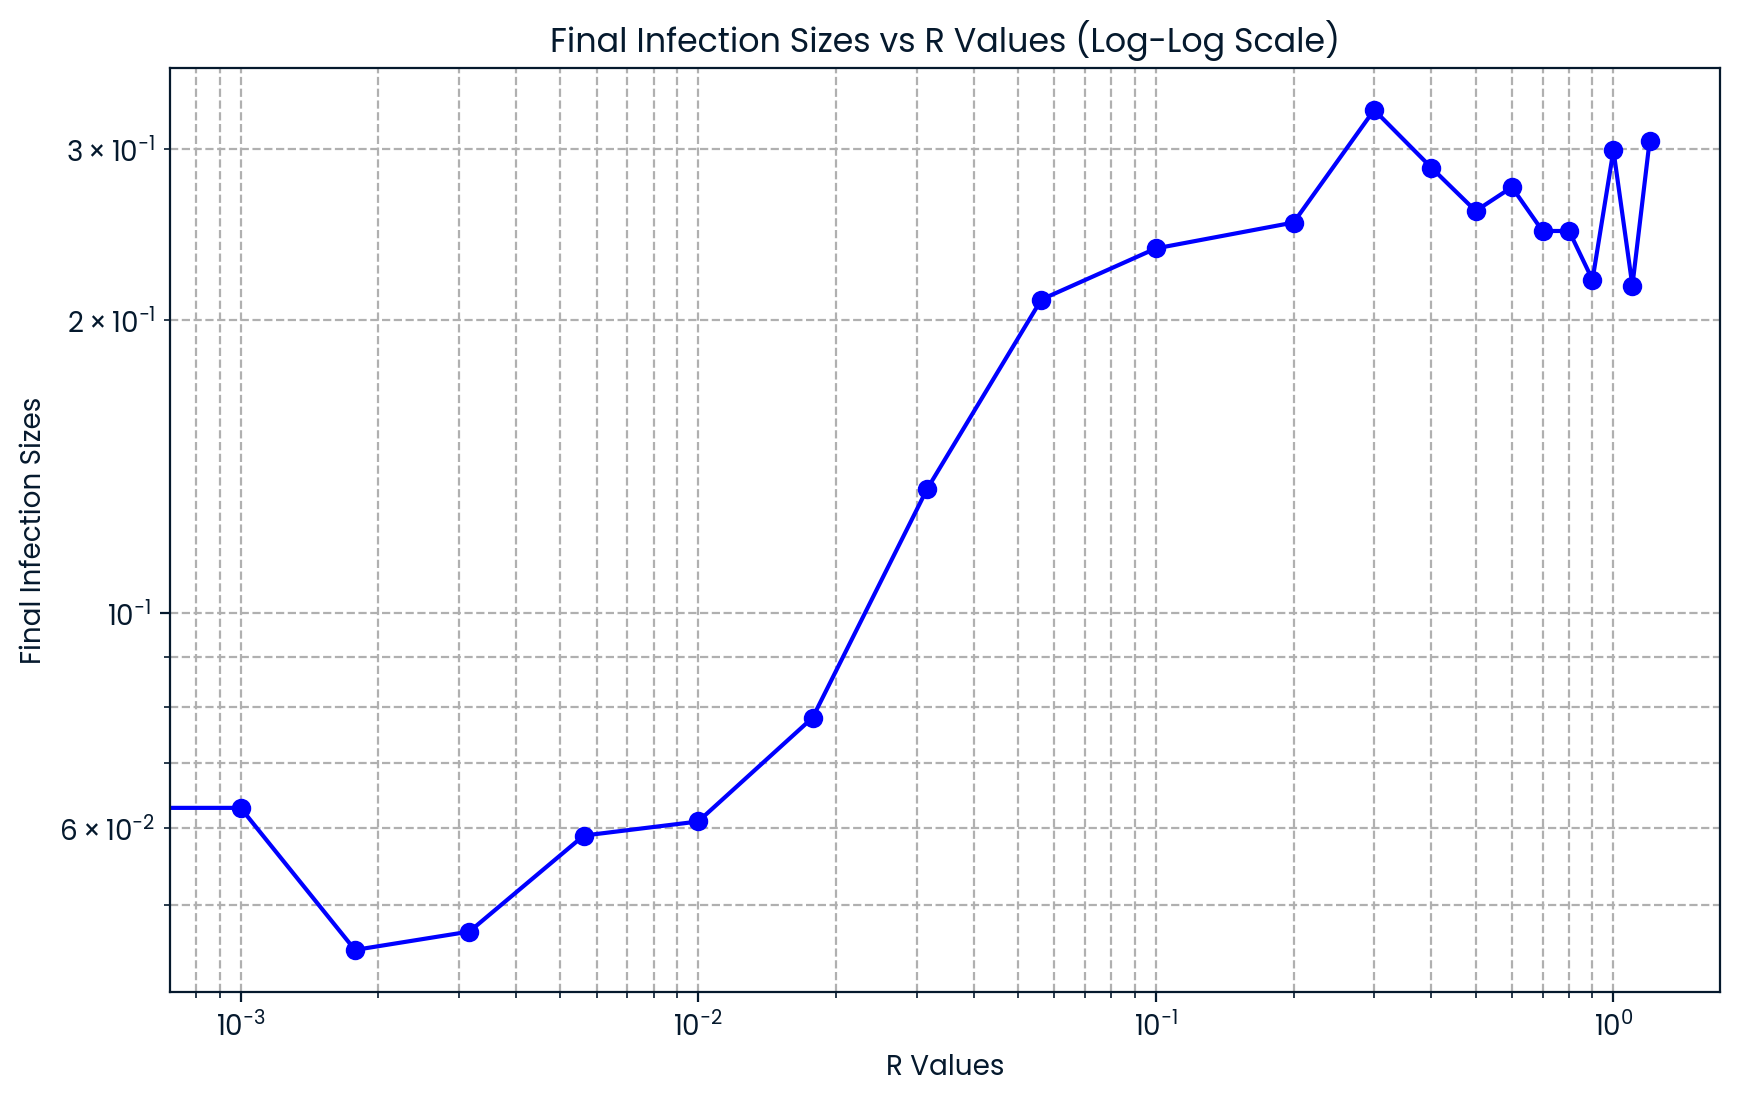

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.loglog(R_values, final_infection_sizes, marker='o', linestyle='-', color='b')
plt.title('Final Infection Sizes vs R Values (Log-Log Scale)')
plt.xlabel('R Values')
plt.ylabel('Final Infection Sizes')
plt.grid(True, which="both", ls="--")
plt.show()

The plot above depicts the final infection size (or the number of infected at $t=t_{max}=500$) against $R$ of the random geometric network. This figure reveals that increasing $R$ steadily speeds up the infection. In the context of network structure, changing the network structure greatly affects the infection route: attenuating the spread (by reducing $R$) or intensifying it (by increasing $R$).


This is still a preliminary study, and any feedback regarding the initial results nad direction is greatly appreciated. Send them over at jprmaulion[at]gmail[dot]com.